## 1. Import Required Libraries

In [1]:
# PySpark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, lit, when, to_timestamp, year, month, dayofmonth, hour, dayofweek,
    udf, count, sum, avg, min, max, expr
)
from pyspark.sql.types import IntegerType, BooleanType, StringType, FloatType

# PySpark ML libraries
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler,
    Imputer, Bucketizer
)
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier, GBTClassifier,
    DecisionTreeClassifier, NaiveBayes
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# For SMOTE implementation
from pyspark.ml.feature import VectorAssembler
import numpy as np

# Hyperparameter optimization library
import optuna
from optuna.visualization import plot_param_importances, plot_optimization_history

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set visualization styles
plt.style.use('ggplot')
sns.set_palette('Set2')

from imblearn.over_sampling import SMOTE
from pyspark.ml.linalg import Vectors
import builtins

# Set random seed for reproducibility
import random
random.seed(42)

/Users/huiyu/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Initialize Spark Session

In [2]:
# Initialize Spark Session with increased timeout and memory settings
spark = SparkSession.builder \
    .appName("EVAccidentAnalysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "120s") \
    .config("spark.python.worker.timeout", "300") \
    .config("spark.rpc.askTimeout", "300s") \
    .config("spark.task.maxFailures", "4") \
    .getOrCreate()

# Set log level to minimize verbose output
spark.sparkContext.setLogLevel("ERROR")

# Check Spark version
print(f"Spark Version: {spark.version}")

25/04/13 22:10:59 WARN Utils: Your hostname, Huis-Surface-Laptop-3.local resolves to a loopback address: 127.0.0.1; using 192.168.1.211 instead (on interface en0)
25/04/13 22:10:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/13 22:10:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.1


## 3. Loading and Initial Data Exploration

In [3]:
# Load the dataset
df = spark.read.option("header", True).csv("final_data")
df = df.withColumn("ZIP CODE", col("ZIP CODE").cast(IntegerType()))

# Display basic information about the dataset
print(f"Dataset shape: ({df.count()}, {len(df.columns)})")
print("\nData schema:")
df.printSchema()

# Display first few rows of the dataset
df.show(5)

# Filter only electric vehicles
ev_df = df.filter(col("is_e_vehicle") == True)
print(f"Number of electric vehicle accidents: {ev_df.count()}")

# Create target variable for binary classification (0: no injury/death, 1: injury/death)
ev_df = ev_df.withColumn(
    "CAUSALITY", 
    when(
        (col("NUMBER OF PERSONS INJURED") > 0) | (col("NUMBER OF PERSONS KILLED") > 0), 
        1
    ).otherwise(0)
)

# Check class distribution
causality_counts = ev_df.groupBy("CAUSALITY").count().orderBy("CAUSALITY")
causality_counts.show()

# Convert to pandas for percentage calculation
causality_pd = causality_counts.toPandas()
total = causality_pd['count'].sum()
for i, row in causality_pd.iterrows():
    print(f"Class {row['CAUSALITY']} ({'no injury/death' if row['CAUSALITY'] == 0 else 'injury/death'}): {row['count']/total*100:.2f}%")

Dataset shape: (1748161, 29)

Data schema:
root
 |-- CRASH DATE & TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: string (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: string (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: string (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: string (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 3: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 4: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 5: 

+---------+-----+
|CAUSALITY|count|
+---------+-----+
|        0| 3897|
|        1|14634|
+---------+-----+



Class 0 (no injury/death): 21.03%
Class 1 (injury/death): 78.97%


In [4]:
# Data preprocessing - Create temporal features
ev_df = ev_df.withColumn("CRASH DATE & TIME", to_timestamp(col("CRASH DATE & TIME")))

# Extract temporal features
ev_df = ev_df.withColumn("Year", year(col("CRASH DATE & TIME")))
ev_df = ev_df.withColumn("Month", month(col("CRASH DATE & TIME")))
ev_df = ev_df.withColumn("Day", dayofmonth(col("CRASH DATE & TIME")))
ev_df = ev_df.withColumn("Hour", hour(col("CRASH DATE & TIME")))
ev_df = ev_df.withColumn("DayOfWeek", dayofweek(col("CRASH DATE & TIME")) - 1)  # 0: Sunday, 6: Saturday

# Display examples of the new features
ev_df.select("CRASH DATE & TIME", "Year", "Month", "Day", "Hour", "DayOfWeek").show(5)

+-------------------+----+-----+---+----+---------+
|  CRASH DATE & TIME|Year|Month|Day|Hour|DayOfWeek|
+-------------------+----+-----+---+----+---------+
|2017-04-21 18:02:00|2017|    4| 21|  18|        5|
|2017-04-28 18:50:00|2017|    4| 28|  18|        5|
|2017-05-05 14:20:00|2017|    5|  5|  14|        5|
|2017-05-12 18:35:00|2017|    5| 12|  18|        5|
|2017-06-11 03:05:00|2017|    6| 11|   3|        0|
+-------------------+----+-----+---+----+---------+
only showing top 5 rows



## 4. Feature Selection and Engineering

In [5]:
# Select base features for modeling
features = [
    "Month", "Day", "Hour", "DayOfWeek", 
    "VEHICLE TYPE CODE 2", "ZIP CODE", "CONTRIBUTING FACTOR VEHICLE 1"
]

target_classification = "CAUSALITY"

# Remove rows with missing values in the selected features
df_clean = ev_df.dropna(subset=features + [target_classification])

print(f"Original dataset count: {ev_df.count()}")
print(f"Clean dataset count: {df_clean.count()}")

# Create additional time-based features
# Rush hour: 7-9 AM and 4-7 PM
df_clean = df_clean.withColumn(
    "IsRushHour", 
    when(
        ((col("Hour") >= 7) & (col("Hour") <= 9)) | 
        ((col("Hour") >= 16) & (col("Hour") <= 19)),
        1
    ).otherwise(0)
)

# Night time: 10 PM to 5 AM
df_clean = df_clean.withColumn(
    "IsNightTime", 
    when(
        (col("Hour") >= 22) | (col("Hour") <= 5),
        1
    ).otherwise(0)
)

# Weekend: Saturday (5) and Sunday (6)
df_clean = df_clean.withColumn(
    "IsWeekend", 
    when(
        col("DayOfWeek") >= 5,
        1
    ).otherwise(0)
)

# Add the new features to our feature list
features.extend(["IsRushHour", "IsWeekend", "IsNightTime"])

# Display statistics for the new features
df_clean.select("IsRushHour", "IsWeekend", "IsNightTime").summary().show()

Original dataset count: 18531


Clean dataset count: 15226


+-------+------------------+------------------+-------------------+
|summary|        IsRushHour|         IsWeekend|        IsNightTime|
+-------+------------------+------------------+-------------------+
|  count|             15226|             15226|              15226|
|   mean|0.3958360698804676|0.2974517273085512|0.16511230789439119|
| stddev|0.4890455841447253|0.4571519692147792|0.37129407196818964|
|    min|                 0|                 0|                  0|
|    25%|                 0|                 0|                  0|
|    50%|                 0|                 0|                  0|
|    75%|                 1|                 1|                  0|
|    max|                 1|                 1|                  1|
+-------+------------------+------------------+-------------------+



## 5. Data Preparation for ML

In [6]:
# Identify categorical and numerical features
categorical_features = ["Month", "Hour", "DayOfWeek", "VEHICLE TYPE CODE 2", "CONTRIBUTING FACTOR VEHICLE 1"]
numerical_features = ["Day", "ZIP CODE", "IsRushHour", "IsWeekend", "IsNightTime"]

# Create stages for the pipeline
stages = []

# Process categorical features
for feature in categorical_features:
    # StringIndexer: Converts string column to indices
    indexer = StringIndexer(inputCol=feature, outputCol=f"{feature}_indexed", handleInvalid="keep")
    
    # OneHotEncoder: Creates binary vectors from categorical features
    encoder = OneHotEncoder(inputCols=[f"{feature}_indexed"], outputCols=[f"{feature}_encoded"], dropLast=True)
    
    stages += [indexer, encoder]

# Process numerical features - no transformation needed, they're already numeric
# Just create a list of feature names after all the transformations
encoded_categorical_features = [f"{feature}_encoded" for feature in categorical_features]
feature_names = numerical_features + encoded_categorical_features

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_names, outputCol="features", handleInvalid="skip")
stages += [assembler]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Create train-test split
train_val_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)
train_data, val_data = train_val_data.randomSplit([0.8, 0.2], seed=42)

print(f"Training data count: {train_data.count()}")
print(f"Validation data count: {val_data.count()}")
print(f"Test data count: {test_data.count()}")

# Fit the pipeline on training data
pipeline_model = pipeline.fit(train_val_data)

# Transform the data
train_data_transformed = pipeline_model.transform(train_data)
val_data_transformed = pipeline_model.transform(val_data)
test_data_transformed = pipeline_model.transform(test_data)

# Initialize the evaluator
binary_evaluator = BinaryClassificationEvaluator(
    labelCol=target_classification,
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

Training data count: 9830


Validation data count: 2381


Test data count: 3015


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=45478Kb max_used=45515Kb free=85593Kb
 bounds [0x00000001061e0000, 0x0000000108ee0000, 0x000000010e1e0000]
 total_blobs=14295 nmethods=13305 adapters=900
 compilation: disabled (not enough contiguous free space left)


## 6. SMOTE Implementation for Class Imbalance

We'll implement a PySpark version of SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance.

In [7]:
# Check class distribution in training data
class_distribution = train_data_transformed.groupBy(target_classification).count().orderBy(target_classification)
class_distribution.show()

# Define a simple SMOTE function
def apply_smote(spark_df, feature_col="features", label_col="CAUSALITY", sampling_ratio=0.6):
    # 1. Convert PySpark DataFrame to Pandas
    pandas_df = spark_df.select(feature_col, label_col).toPandas()
    print(f"Original DataFrame shape: {pandas_df.shape}")
    
    # 2. Extract features and labels
    X = np.array([x.toArray() for x in pandas_df[feature_col]])
    y = pandas_df[label_col].values
    
    # Print class distribution before SMOTE
    unique, counts = np.unique(y, return_counts=True)
    class_counts_dict = dict(zip(unique, counts))
    print(f"Class distribution before SMOTE: {class_counts_dict}")
    
    # 3. Apply SMOTE
    # Calculate appropriate k_neighbors
    min_class_count = np.min(counts)
    k_neighbors = builtins.min(5, int(min_class_count) - 1)  # Ensure it's not larger than minority class-1
    print(f"Using k_neighbors={k_neighbors} for SMOTE")
    
    smote = SMOTE(
        sampling_strategy=sampling_ratio,
        k_neighbors=k_neighbors,
        random_state=42
    )
    
    # Apply SMOTE and get resampled data
    try:
        X_resampled, y_resampled = smote.fit_resample(X, y)
        print(f"Resampled feature matrix shape: {X_resampled.shape}")
        print(f"Resampled label vector shape: {y_resampled.shape}")
        unique_resampled, counts_resampled = np.unique(y_resampled, return_counts=True)
        print(f"Class distribution after SMOTE: {dict(zip(unique_resampled, counts_resampled))}")
    except Exception as e:
        print(f"SMOTE application failed with error: {e}")
        print("Falling back to original data")
        X_resampled, y_resampled = X, y
    
    # 4. Convert resampled data back to PySpark DataFrame
    # First create a DataFrame with all features as separate columns
    features_df = pd.DataFrame(X_resampled, columns=[f'feature_{i}' for i in range(X_resampled.shape[1])])
    features_df[label_col] = y_resampled.astype(int)
    
    # 5. Create a PySpark DataFrame from the pandas DataFrame
    try:
        # Convert in batches
        batch_size = 1000
        num_batches = len(features_df) // batch_size + (1 if len(features_df) % batch_size else 0)
        print(f"Converting data back to PySpark in {num_batches} batches")
        
        # Process first batch
        first_batch = features_df.iloc[:batch_size]
        resampled_spark = spark.createDataFrame(first_batch)
        
        # Process remaining batches
        for i in range(1, num_batches):
            start_idx = i * batch_size
            end_idx = builtins.min((i + 1) * batch_size, len(features_df))
            batch_df = features_df.iloc[start_idx:end_idx]
            batch_spark = spark.createDataFrame(batch_df)
            resampled_spark = resampled_spark.union(batch_spark)

        print("Successfully converted data back to PySpark DataFrame")
    except Exception as e:
        print(f"Error during conversion to PySpark: {e}")
        resampled_spark = spark.createDataFrame(features_df)
    
    # 6. Reassemble the feature columns into a vector column
    from pyspark.ml.feature import VectorAssembler
    feature_cols = [f'feature_{i}' for i in range(X_resampled.shape[1])]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol=feature_col)
    
    # 7. Apply the assembler and select only the needed columns
    result_df = assembler.transform(resampled_spark).select(feature_col, label_col)
    
    # Cache the result for better performance
    result_df = result_df.cache()
    
    # Force computation to cache the data
    result_count = result_df.count()
    print(f"Successfully resampled data with {result_count} records")
    
    return result_df

# Apply SMOTE to training data
train_balanced = apply_smote(train_data_transformed, "features", target_classification)

# Verify the class distribution in the balanced dataset
train_balanced.groupBy(target_classification).count().orderBy(target_classification).show()

+---------+-----+
|CAUSALITY|count|
+---------+-----+
|        0| 2365|
|        1| 7465|
+---------+-----+



Original DataFrame shape: (9830, 2)
Class distribution before SMOTE: {0: 2365, 1: 7465}
Using k_neighbors=5 for SMOTE
Resampled feature matrix shape: (11944, 110)
Resampled label vector shape: (11944,)
Class distribution after SMOTE: {0: 4479, 1: 7465}
Converting data back to PySpark in 12 batches
Successfully converted data back to PySpark DataFrame


Successfully resampled data with 11944 records
+---------+-----+
|CAUSALITY|count|
+---------+-----+
|        0| 4479|
|        1| 7465|
+---------+-----+



## 7. Hyperparameter Tuning with Optuna

In [8]:
# Define objective function for Random Forest optimization
def objective_rf(trial):
    # Parameters to optimize
    num_trees = trial.suggest_int('numTrees', 10, 100, step=10)
    max_depth = trial.suggest_int('maxDepth', 5, 20, step=5)
    impurity = trial.suggest_categorical('impurity', ['gini', 'entropy'])
    min_instances_per_node = trial.suggest_int('minInstancesPerNode', 1, 10)
    
    # Create model with suggested parameters
    rf = RandomForestClassifier(
        featuresCol="features",
        labelCol=target_classification,
        numTrees=num_trees,
        maxDepth=max_depth,
        impurity=impurity,
        minInstancesPerNode=min_instances_per_node,
        seed=42
    )
    
    # Train and evaluate model
    model = rf.fit(train_balanced)
    predictions = model.transform(val_data_transformed)
    auc_score = binary_evaluator.evaluate(predictions)
    
    return auc_score

# Create a study for Random Forest
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(objective_rf, n_trials=5)

# Print results
print(f"\nBest trial for Random Forest:")
print(f"  Value (ROC AUC): {rf_study.best_value:.4f}")
print(f"  Params:")
for key, value in rf_study.best_params.items():
    print(f"    {key}: {value}")

# Create best Random Forest model
best_rf = RandomForestClassifier(
    featuresCol="features",
    labelCol=target_classification,
    numTrees=rf_study.best_params['numTrees'],
    maxDepth=rf_study.best_params['maxDepth'],
    impurity=rf_study.best_params['impurity'],
    minInstancesPerNode=rf_study.best_params['minInstancesPerNode'],
    seed=42
)

[I 2025-04-13 22:11:36,649] A new study created in memory with name: no-name-f2e88e07-4f07-4f22-880f-5565482d6427
[I 2025-04-13 22:13:27,150] Trial 0 finished with value: 0.5431297702598706 and parameters: {'numTrees': 80, 'maxDepth': 10, 'impurity': 'gini', 'minInstancesPerNode': 2}. Best is trial 0 with value: 0.5431297702598706.
[I 2025-04-13 22:14:22,233] Trial 1 finished with value: 0.5456966186690003 and parameters: {'numTrees': 50, 'maxDepth': 20, 'impurity': 'entropy', 'minInstancesPerNode': 7}. Best is trial 1 with value: 0.5456966186690003.
[I 2025-04-13 22:14:34,655] Trial 2 finished with value: 0.5396757998491557 and parameters: {'numTrees': 30, 'maxDepth': 10, 'impurity': 'entropy', 'minInstancesPerNode': 1}. Best is trial 1 with value: 0.5456966186690003.
[I 2025-04-13 22:14:41,661] Trial 3 finished with value: 0.5182073514538438 and parameters: {'numTrees': 80, 'maxDepth': 5, 'impurity': 'gini', 'minInstancesPerNode': 2}. Best is trial 1 with value: 0.5456966186690003.
[


Best trial for Random Forest:
  Value (ROC AUC): 0.5511
  Params:
    numTrees: 90
    maxDepth: 10
    impurity: gini
    minInstancesPerNode: 7


In [9]:
# Define objective function for GBT optimization
def objective_gbt(trial):
    # Parameters to optimize
    max_iter = trial.suggest_int('maxIter', 10, 50, step=5)
    max_depth = trial.suggest_int('maxDepth', 3, 15, step=3)
    step_size = trial.suggest_float('stepSize', 0.01, 0.3, log=True)
    
    # Create model with suggested parameters
    gbt = GBTClassifier(
        featuresCol="features",
        labelCol=target_classification,
        maxIter=max_iter,
        maxDepth=max_depth,
        stepSize=step_size,
        seed=42
    )
    
    # Train and evaluate model
    model = gbt.fit(train_balanced)
    predictions = model.transform(val_data_transformed)
    auc_score = binary_evaluator.evaluate(predictions)
    
    return auc_score

# Create a study for GBT
gbt_study = optuna.create_study(direction='maximize')
gbt_study.optimize(objective_gbt, n_trials=5)

# Print results
print(f"\nBest trial for Gradient Boosting Tree:")
print(f"  Value (ROC AUC): {gbt_study.best_value:.4f}")
print(f"  Params:")
for key, value in gbt_study.best_params.items():
    print(f"    {key}: {value}")

# Create best GBT model
best_gbt = GBTClassifier(
    featuresCol="features",
    labelCol=target_classification,
    maxIter=gbt_study.best_params['maxIter'],
    maxDepth=gbt_study.best_params['maxDepth'],
    stepSize=gbt_study.best_params['stepSize'],
    seed=42
)

[I 2025-04-13 22:15:03,868] A new study created in memory with name: no-name-58decabc-b219-480e-a781-16c35a9f6887
[I 2025-04-13 22:15:34,097] Trial 0 finished with value: 0.560849180623605 and parameters: {'maxIter': 45, 'maxDepth': 3, 'stepSize': 0.14814368921667037}. Best is trial 0 with value: 0.560849180623605.
[I 2025-04-13 22:17:21,274] Trial 1 finished with value: 0.5380795559880015 and parameters: {'maxIter': 35, 'maxDepth': 9, 'stepSize': 0.1645380686881988}. Best is trial 0 with value: 0.560849180623605.
[I 2025-04-13 22:18:24,645] Trial 2 finished with value: 0.5356916672903869 and parameters: {'maxIter': 45, 'maxDepth': 6, 'stepSize': 0.19031035832179446}. Best is trial 0 with value: 0.560849180623605.
[I 2025-04-13 22:19:18,955] Trial 3 finished with value: 0.5465218484379167 and parameters: {'maxIter': 10, 'maxDepth': 12, 'stepSize': 0.03133822672587567}. Best is trial 0 with value: 0.560849180623605.
[I 2025-04-13 22:20:49,910] Trial 4 finished with value: 0.558814413501


Best trial for Gradient Boosting Tree:
  Value (ROC AUC): 0.5608
  Params:
    maxIter: 45
    maxDepth: 3
    stepSize: 0.14814368921667037


In [10]:
# Define objective function for Logistic Regression optimization
def objective_lr(trial):
    # Parameters to optimize
    reg_param = trial.suggest_float('regParam', 0.01, 1.0, log=True)
    elastic_net_param = trial.suggest_float('elasticNetParam', 0.0, 1.0)
    max_iter = trial.suggest_int('maxIter', 10, 100)
    
    # Create model with suggested parameters
    lr = LogisticRegression(
        featuresCol="features",
        labelCol=target_classification,
        regParam=reg_param,
        elasticNetParam=elastic_net_param,
        maxIter=max_iter
    )
    
    # Train and evaluate model
    model = lr.fit(train_balanced)
    predictions = model.transform(val_data_transformed)
    auc_score = binary_evaluator.evaluate(predictions)
    
    return auc_score

# Create a study for Logistic Regression
lr_study = optuna.create_study(direction='maximize')
lr_study.optimize(objective_lr, n_trials=5)

# Print results
print(f"\nBest trial for Logistic Regression:")
print(f"  Value (ROC AUC): {lr_study.best_value:.4f}")
print(f"  Params:")
for key, value in lr_study.best_params.items():
    print(f"    {key}: {value}")

# Create best Logistic Regression model
best_lr = LogisticRegression(
    featuresCol="features",
    labelCol=target_classification,
    regParam=lr_study.best_params['regParam'],
    elasticNetParam=lr_study.best_params['elasticNetParam'],
    maxIter=lr_study.best_params['maxIter']
)

[I 2025-04-13 22:20:49,927] A new study created in memory with name: no-name-e98d7007-905d-4b8f-a45c-8ff759cb8e6c
[I 2025-04-13 22:20:53,555] Trial 0 finished with value: 0.5 and parameters: {'regParam': 0.12904957172368584, 'elasticNetParam': 0.40043906559894893, 'maxIter': 45}. Best is trial 0 with value: 0.5.
[I 2025-04-13 22:20:55,579] Trial 1 finished with value: 0.5 and parameters: {'regParam': 0.2431406275143255, 'elasticNetParam': 0.43511106635394503, 'maxIter': 82}. Best is trial 0 with value: 0.5.
[I 2025-04-13 22:20:59,019] Trial 2 finished with value: 0.5633728484052916 and parameters: {'regParam': 0.02908238690861905, 'elasticNetParam': 0.03589325762886475, 'maxIter': 10}. Best is trial 2 with value: 0.5633728484052916.
[I 2025-04-13 22:21:00,937] Trial 3 finished with value: 0.5 and parameters: {'regParam': 0.27773058640640763, 'elasticNetParam': 0.240420842743986, 'maxIter': 14}. Best is trial 2 with value: 0.5633728484052916.
[I 2025-04-13 22:21:04,960] Trial 4 finished


Best trial for Logistic Regression:
  Value (ROC AUC): 0.5694
  Params:
    regParam: 0.011757940940532965
    elasticNetParam: 0.5503927294421549
    maxIter: 96


## 8. Model Training and Evaluation (Before Class Balancing)

In [11]:
# Initialize models with optimized parameters
unbalanced_models = {
    "Logistic Regression (Optimized)": best_lr,
    "Random Forest (Optimized)": best_rf,
    "Gradient Boosting (Optimized)": best_gbt,
    "Decision Tree": DecisionTreeClassifier(featuresCol="features", labelCol=target_classification, maxDepth=5),
    "Naive Bayes": NaiveBayes(featuresCol="features", labelCol=target_classification)
}

# Define evaluation metrics
evaluators = {
    "Area Under ROC": BinaryClassificationEvaluator(
        labelCol=target_classification, rawPredictionCol="rawPrediction", metricName="areaUnderROC"
    ),
    "Area Under PR": BinaryClassificationEvaluator(
        labelCol=target_classification, rawPredictionCol="rawPrediction", metricName="areaUnderPR"
    ),
    "Accuracy": MulticlassClassificationEvaluator(
        labelCol=target_classification, predictionCol="prediction", metricName="accuracy"
    ),
    "WeightedPrecision": MulticlassClassificationEvaluator(
        labelCol=target_classification, predictionCol="prediction", metricName="weightedPrecision"
    ),
    "WeightedRecall": MulticlassClassificationEvaluator(
        labelCol=target_classification, predictionCol="prediction", metricName="weightedRecall"
    ),
    "F1 Score": MulticlassClassificationEvaluator(
        labelCol=target_classification, predictionCol="prediction", metricName="f1"
    )
}

# Train models and evaluate (on unbalanced data)
unbalanced_results = {}

for model_name, model in unbalanced_models.items():
    print(f"\nTraining {model_name} on unbalanced data...")
    model_fitted = model.fit(train_data_transformed)
    predictions = model_fitted.transform(test_data_transformed)
    
    # Calculate metrics
    model_results = {}
    for metric_name, evaluator in evaluators.items():
        score = evaluator.evaluate(predictions)
        model_results[metric_name] = score
        print(f"{metric_name}: {score:.4f}")
    
    unbalanced_results[model_name] = model_results


Training Logistic Regression (Optimized) on unbalanced data...


Area Under ROC: 0.5364


Area Under PR: 0.7942


Accuracy: 0.7698


WeightedPrecision: 0.5935


WeightedRecall: 0.7698


F1 Score: 0.6703

Training Random Forest (Optimized) on unbalanced data...


Area Under ROC: 0.5285


Area Under PR: 0.7926


Accuracy: 0.7705


WeightedPrecision: 0.5936


WeightedRecall: 0.7705


F1 Score: 0.6706

Training Gradient Boosting (Optimized) on unbalanced data...


Area Under ROC: 0.5254


Area Under PR: 0.7910


Accuracy: 0.7695


WeightedPrecision: 0.6824


WeightedRecall: 0.7695


F1 Score: 0.6732

Training Decision Tree on unbalanced data...


Area Under ROC: 0.4955


Area Under PR: 0.7714


Accuracy: 0.7678


WeightedPrecision: 0.6708


WeightedRecall: 0.7678


F1 Score: 0.6741

Training Naive Bayes on unbalanced data...


Area Under ROC: 0.5020


Area Under PR: 0.7778


Accuracy: 0.7705


WeightedPrecision: 0.7091


WeightedRecall: 0.7705


F1 Score: 0.6737


## 9. Model Training and Evaluation (After Class Balancing)

In [12]:
# Initialize models with the same parameters for balanced data
balanced_models = {
    "Logistic Regression (Optimized)": best_lr,
    "Random Forest (Optimized)": best_rf,
    "Gradient Boosting (Optimized)": best_gbt,
    "Decision Tree": DecisionTreeClassifier(featuresCol="features", labelCol=target_classification, maxDepth=5),
    "Naive Bayes": NaiveBayes(featuresCol="features", labelCol=target_classification)
}

# Train models and evaluate (on balanced data)
balanced_results = {}
best_models = {}

for model_name, model in balanced_models.items():
    print(f"\nTraining {model_name} on balanced data...")
    model_fitted = model.fit(train_balanced)
    predictions = model_fitted.transform(test_data_transformed)
    
    best_models[model_name] = model_fitted
    
    # Calculate metrics
    model_results = {}
    for metric_name, evaluator in evaluators.items():
        score = evaluator.evaluate(predictions)
        model_results[metric_name] = score
        print(f"{metric_name}: {score:.4f}")
    
    balanced_results[model_name] = model_results


Training Logistic Regression (Optimized) on balanced data...


Area Under ROC: 0.5352


Area Under PR: 0.7915


Accuracy: 0.7695


WeightedPrecision: 0.6889


WeightedRecall: 0.7695


F1 Score: 0.6744

Training Random Forest (Optimized) on balanced data...


Area Under ROC: 0.5274


Area Under PR: 0.7977


Accuracy: 0.7705


WeightedPrecision: 0.5936


WeightedRecall: 0.7705


F1 Score: 0.6706

Training Gradient Boosting (Optimized) on balanced data...


Area Under ROC: 0.5229


Area Under PR: 0.7922


Accuracy: 0.7698


WeightedPrecision: 0.6703


WeightedRecall: 0.7698


F1 Score: 0.6715

Training Decision Tree on balanced data...


Area Under ROC: 0.4819


Area Under PR: 0.7643


Accuracy: 0.7701


WeightedPrecision: 0.5936


WeightedRecall: 0.7701


F1 Score: 0.6704

Training Naive Bayes on balanced data...


Area Under ROC: 0.5020


Area Under PR: 0.7778


Accuracy: 0.7559


WeightedPrecision: 0.6543


WeightedRecall: 0.7559


F1 Score: 0.6764


## 10. Comparison of Results (Before vs. After Class Balancing)

Model Comparison:


,Model,Area Under ROC,Area Under PR,Accuracy,WeightedPrecision,WeightedRecall,F1 Score,Dataset
0,Logistic Regression (Optimized),0.536393,0.794153,0.769818,0.593523,0.769818,0.670272,Unbalanced
1,Random Forest (Optimized),0.528514,0.792571,0.770481,0.593641,0.770481,0.670598,Unbalanced
2,Gradient Boosting (Optimized),0.525374,0.791035,0.769486,0.682435,0.769486,0.673176,Unbalanced
3,Decision Tree,0.495546,0.771447,0.767828,0.670789,0.767828,0.674116,Unbalanced
4,Naive Bayes,0.501965,0.777833,0.770481,0.709094,0.770481,0.673680,Unbalanced
5,Logistic Regression (Optimized),0.535208,0.791458,0.769486,0.688945,0.769486,0.674377,Balanced (SMOTE)
6,Random Forest (Optimized),0.527411,0.797654,0.770481,0.593641,0.770481,0.670598,Balanced (SMOTE)
7,Gradient Boosting (Optimized),0.522883,0.792195,0.769818,0.670307,0.769818,0.671512,Balanced (SMOTE)
8,Decision Tree,0.481877,0.764272,0.770149,0.593582,0.770149,0.670435,Balanced (SMOTE)
9,Naive Bayes,0.501971,0.777847,0.755887,0.654276,0.755887,0.676437,Balanced (SMOTE)


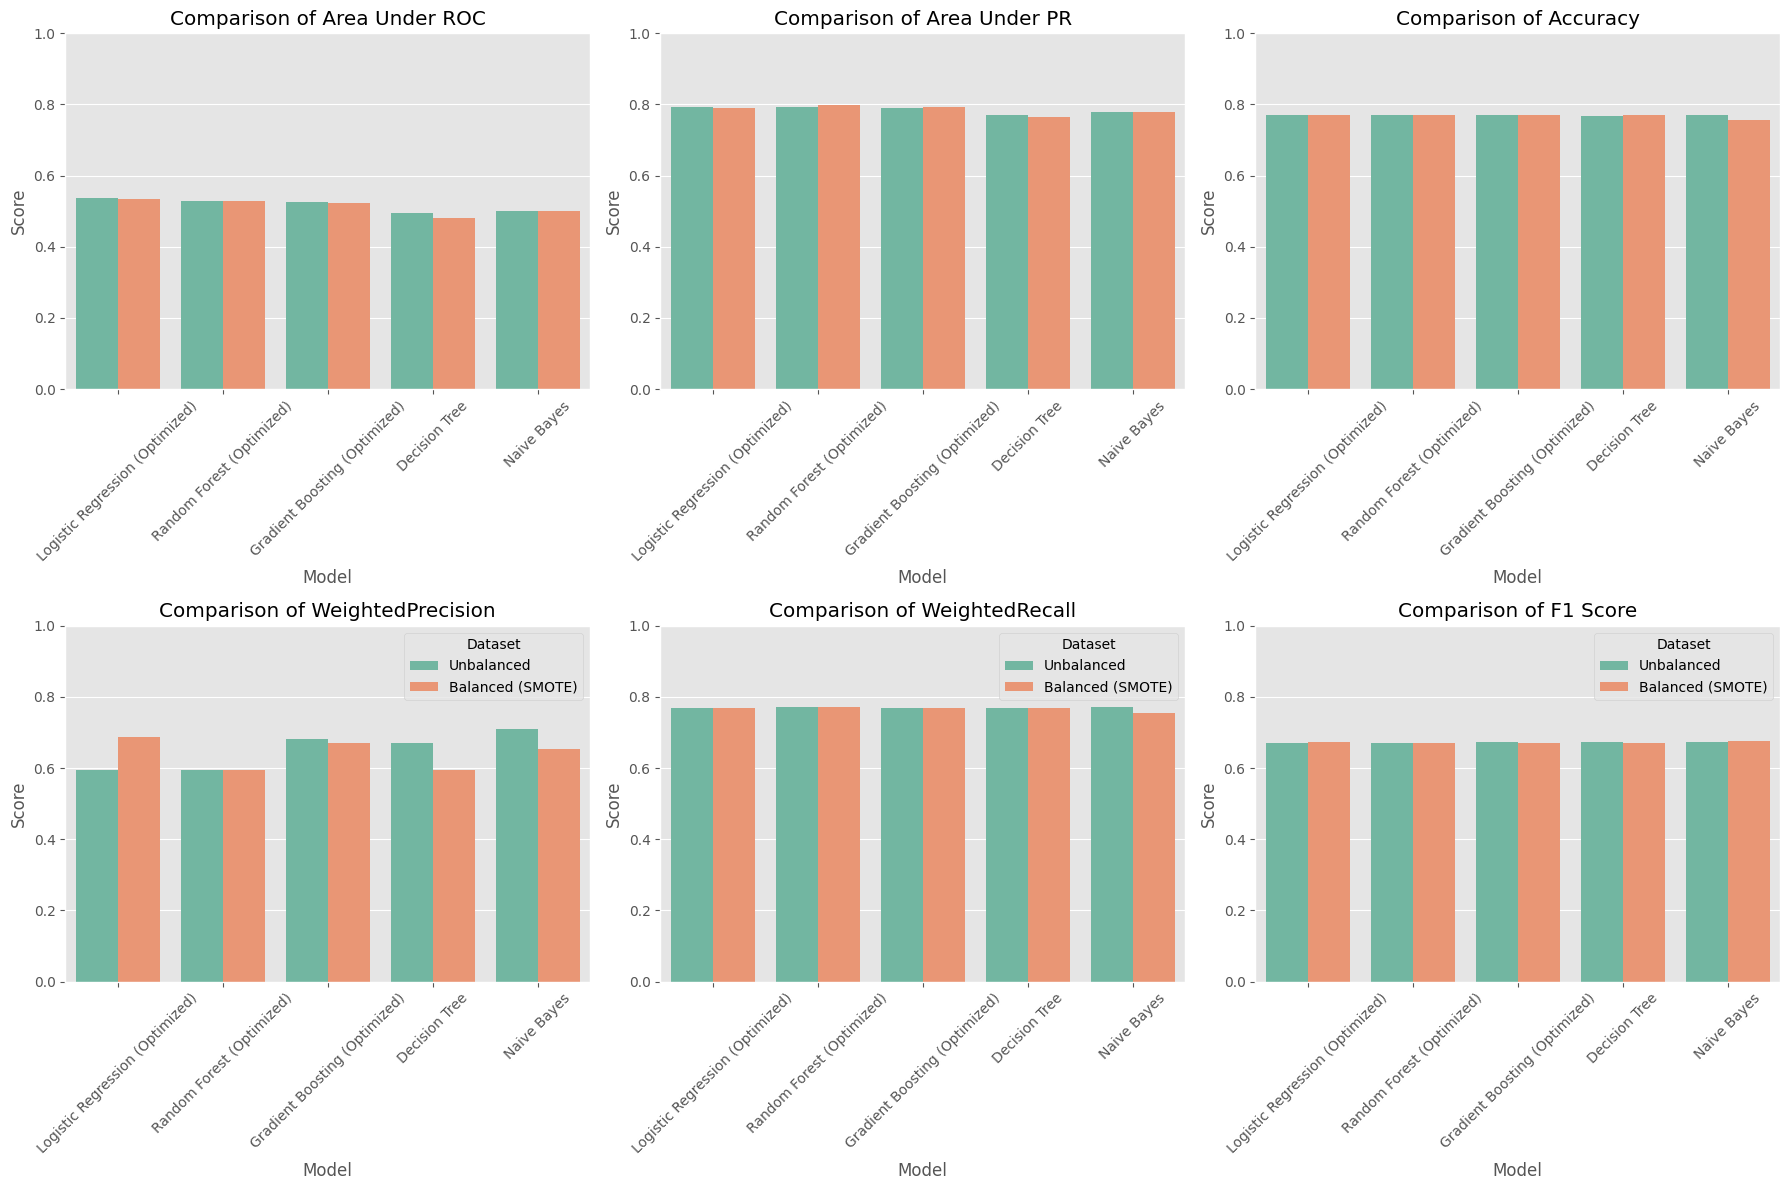

In [13]:
# Convert results to DataFrames for visualization
unbalanced_df = pd.DataFrame(unbalanced_results).T
unbalanced_df['Dataset'] = 'Unbalanced'

balanced_df = pd.DataFrame(balanced_results).T
balanced_df['Dataset'] = 'Balanced (SMOTE)'

# Combine results
all_results = pd.concat([unbalanced_df, balanced_df])
all_results = all_results.reset_index().rename(columns={'index': 'Model'})

# Display results table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print("Model Comparison:")
display(all_results)

# Reshape data for plotting
metrics = ['Area Under ROC', 'Area Under PR', 'Accuracy', 'WeightedPrecision', 'WeightedRecall', 'F1 Score']
plot_data = pd.melt(
    all_results, 
    id_vars=['Model', 'Dataset'], 
    value_vars=metrics, 
    var_name='Metric', 
    value_name='Score'
)

# Plot the comparison for each metric
plt.figure(figsize=(18, 12))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    metric_data = plot_data[plot_data['Metric'] == metric]
    sns.barplot(x='Model', y='Score', hue='Dataset', data=metric_data)
    plt.title(f'Comparison of {metric}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    if i > 3:
        plt.legend(title='Dataset')
    else:
        plt.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

## 11. Feature Importance Analysis for Best Model

In [14]:
# Find the best model based on Area Under ROC
best_model_name = balanced_df['Area Under ROC'].idxmax()
best_model = best_models[best_model_name]
print(f"Best model: {best_model_name} with ROC AUC: {balanced_df.loc[best_model_name, 'Area Under ROC']:.4f}")

# Get feature importance if the best model supports it
if best_model_name in ["Random Forest (Optimized)", "Gradient Boosting (Optimized)", "Decision Tree"]:
    feature_importances = best_model.featureImportances
    importances_array = feature_importances.toArray()
    feature_imp_length = len(importances_array)
    
    # Get the column names after vectorization
    feature_cols = []
    for col in numerical_features:
        feature_cols.append(col)

    for feature in categorical_features:
        # Get the number of categories (subtracting 1 because of one-hot encoding with dropLast=True)
        try:
            num_categories = len(test_data_transformed
                               .select(f"{feature}_indexed")
                               .distinct()
                               .collect()) - 1
            
            for i in range(num_categories):
                feature_cols.append(f"{feature}_{i}")
        except Exception as e:
            print(f"Warning: Error processing feature {feature}: {e}")

    # Check if lengths match and adjust if necessary
    print(f"Number of feature importance values: {feature_imp_length}")
    print(f"Number of feature names: {len(feature_cols)}")
    
    if len(feature_cols) != feature_imp_length:
        print("Warning: Feature names and importance values have different lengths. Adjusting...")
        # Adjust feature columns to match the length of importance values
        if len(feature_cols) > feature_imp_length:
            feature_cols = feature_cols[:feature_imp_length]
        else:
            # If we have more importance values than features, add generic names
            while len(feature_cols) < feature_imp_length:
                feature_cols.append(f"Unknown_Feature_{len(feature_cols)}")

    # Create a DataFrame for visualization
    importances_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances_array
    })

    # Sort by importance
    importances_df = importances_df.sort_values('Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importances_df.head(20))
    plt.title(f'Feature Importances for {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("Top 10 most important features:")
    display(importances_df.head(10))
else:
    print("Feature importance analysis not available for this model type.")

Best model: Logistic Regression (Optimized) with ROC AUC: 0.5352
Feature importance analysis not available for this model type.


## 12. Confusion Matrix

<Figure size 800x600 with 0 Axes>

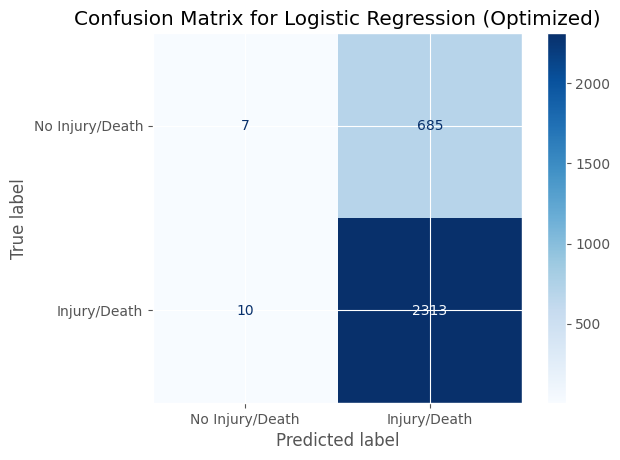

In [15]:
# Get predictions from best model
best_predictions = best_model.transform(test_data_transformed)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert predictions to pandas for sklearn's functions
y_true = best_predictions.select(target_classification).toPandas()
y_pred = best_predictions.select('prediction').toPandas()

# Create and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['No Injury/Death', 'Injury/Death']).plot(cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()


Computing confusion matrix for balanced Logistic Regression (Optimized)...


Confusion Matrix for balanced Logistic Regression (Optimized):
True Negative: 7
False Positive: 685
False Negative: 10
True Positive: 2313
Accuracy: 0.7695
Precision: 0.7715
Recall (Sensitivity): 0.9957
Specificity: 0.0101
F1 Score: 0.8694

Computing confusion matrix for balanced Random Forest (Optimized)...


Confusion Matrix for balanced Random Forest (Optimized):
True Negative: 0
False Positive: 692
False Negative: 0
True Positive: 2323
Accuracy: 0.7705
Precision: 0.7705
Recall (Sensitivity): 1.0000
Specificity: 0.0000
F1 Score: 0.8704

Computing confusion matrix for balanced Gradient Boosting (Optimized)...


Confusion Matrix for balanced Gradient Boosting (Optimized):
True Negative: 2
False Positive: 690
False Negative: 4
True Positive: 2319
Accuracy: 0.7698
Precision: 0.7707
Recall (Sensitivity): 0.9983
Specificity: 0.0029
F1 Score: 0.8698

Computing confusion matrix for balanced Decision Tree...


Confusion Matrix for balanced Decision Tree:
True Negative: 0
False Positive: 692
False Negative: 1
True Positive: 2322
Accuracy: 0.7701
Precision: 0.7704
Recall (Sensitivity): 0.9996
Specificity: 0.0000
F1 Score: 0.8702

Computing confusion matrix for balanced Naive Bayes...


Confusion Matrix for balanced Naive Bayes:
True Negative: 24
False Positive: 668
False Negative: 68
True Positive: 2255
Accuracy: 0.7559
Precision: 0.7715
Recall (Sensitivity): 0.9707
Specificity: 0.0347
F1 Score: 0.8597


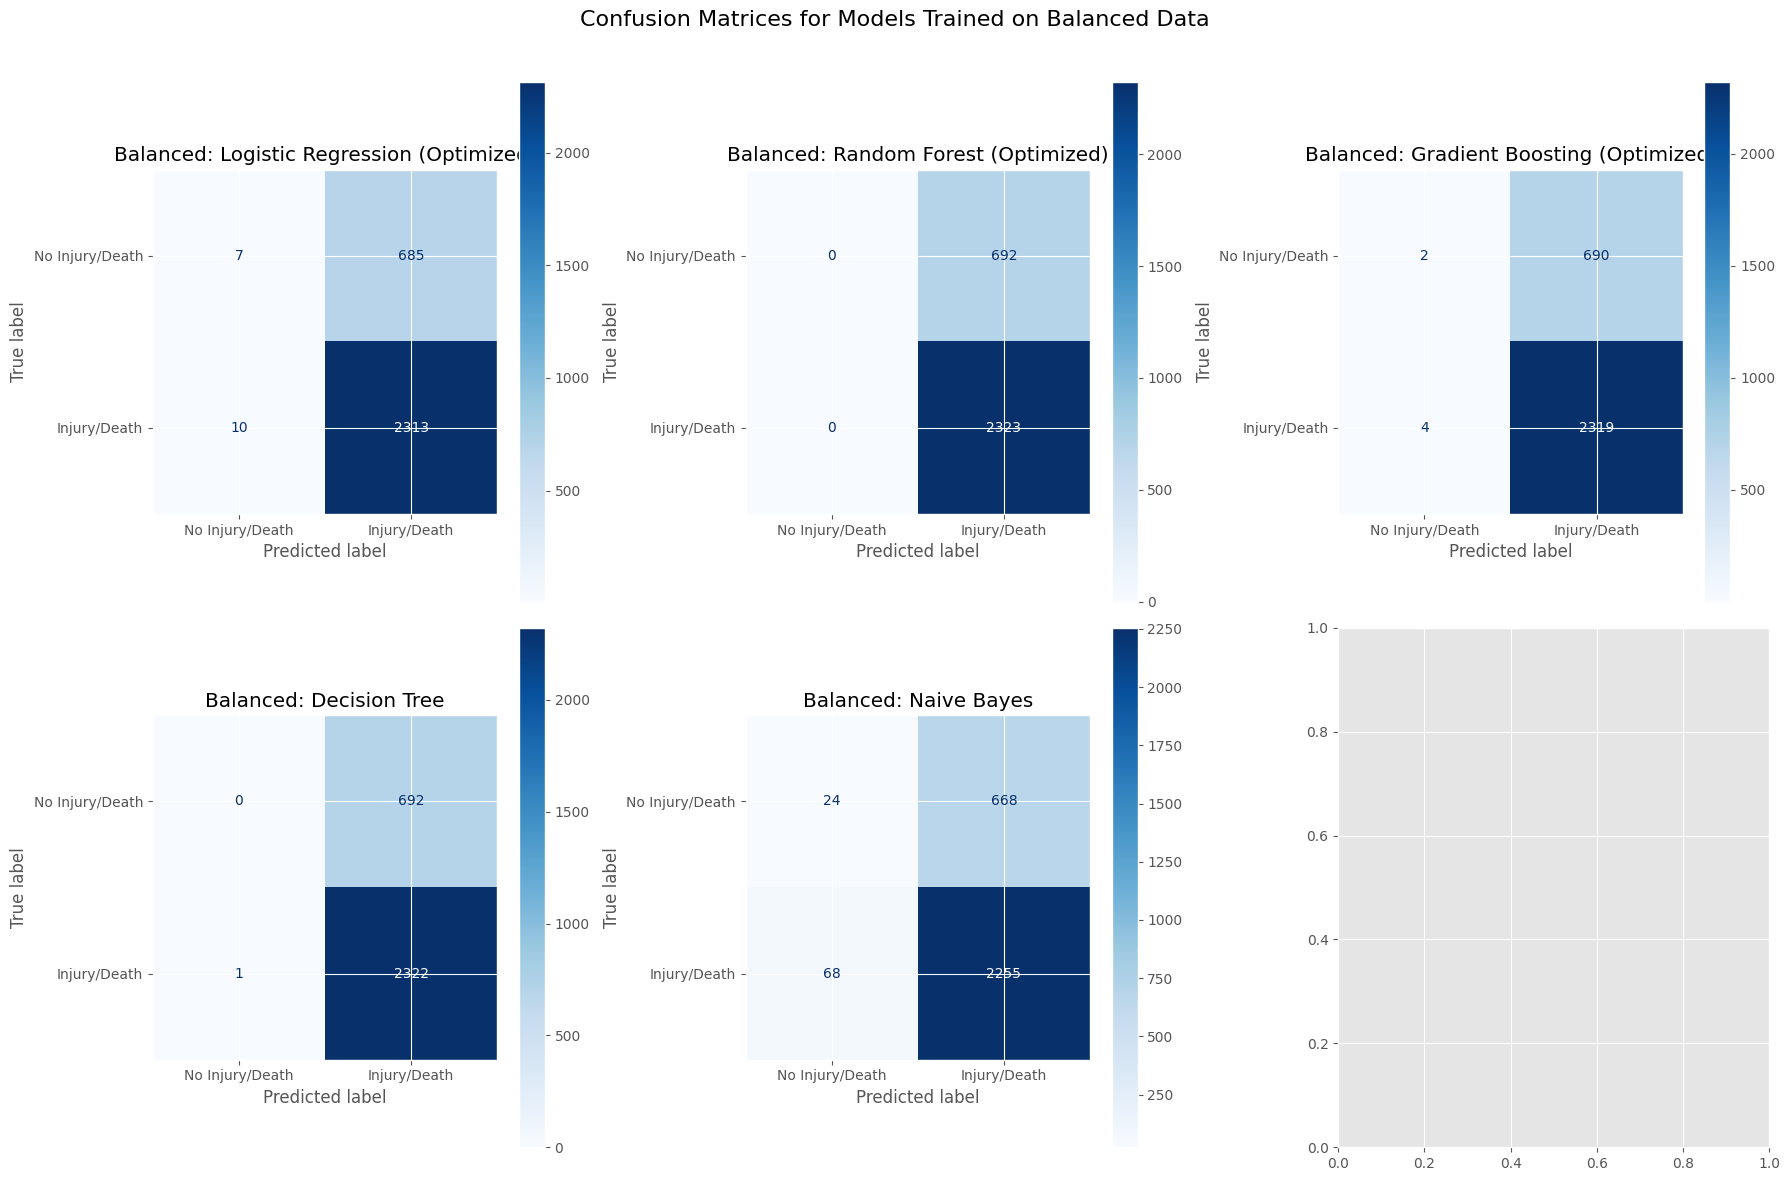

In [17]:
# Generate and plot confusion matrices for all balanced models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create a figure with subplots for each model
num_models = len(balanced_models)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier

# Process each model
for i, (model_name, model) in enumerate(best_models.items()):
    print(f"\nComputing confusion matrix for balanced {model_name}...")
    
    # Generate predictions
    predictions = model.transform(test_data_transformed)
    
    # Convert predictions to pandas for sklearn's functions
    y_true = predictions.select(target_classification).toPandas()
    y_pred = predictions.select('prediction').toPandas()
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot on the corresponding subplot
    if i < len(axes):
        ax = axes[i]
        disp = ConfusionMatrixDisplay(cm, display_labels=['No Injury/Death', 'Injury/Death'])
        disp.plot(ax=ax, cmap='Blues', values_format='d')
        ax.set_title(f'Balanced: {model_name}')
        
        # Print the confusion matrix values
        print(f"Confusion Matrix for balanced {model_name}:")
        print(f"True Negative: {cm[0,0]}")
        print(f"False Positive: {cm[0,1]}")
        print(f"False Negative: {cm[1,0]}")
        print(f"True Positive: {cm[1,1]}")
        
        # Calculate additional metrics
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall (Sensitivity): {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"F1 Score: {f1:.4f}")


plt.tight_layout()
plt.suptitle('Confusion Matrices for Models Trained on Balanced Data', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()


Computing confusion matrix for unbalanced Logistic Regression (Optimized)...


Confusion Matrix for unbalanced Logistic Regression (Optimized):
True Negative: 0
False Positive: 692
False Negative: 2
True Positive: 2321
Accuracy: 0.7698
Precision: 0.7703
Recall (Sensitivity): 0.9991
Specificity: 0.0000
F1 Score: 0.8699

Computing confusion matrix for unbalanced Random Forest (Optimized)...


Confusion Matrix for unbalanced Random Forest (Optimized):
True Negative: 0
False Positive: 692
False Negative: 0
True Positive: 2323
Accuracy: 0.7705
Precision: 0.7705
Recall (Sensitivity): 1.0000
Specificity: 0.0000
F1 Score: 0.8704

Computing confusion matrix for unbalanced Gradient Boosting (Optimized)...


Confusion Matrix for unbalanced Gradient Boosting (Optimized):
True Negative: 5
False Positive: 687
False Negative: 8
True Positive: 2315
Accuracy: 0.7695
Precision: 0.7712
Recall (Sensitivity): 0.9966
Specificity: 0.0072
F1 Score: 0.8695

Computing confusion matrix for unbalanced Decision Tree...


Confusion Matrix for unbalanced Decision Tree:
True Negative: 8
False Positive: 684
False Negative: 16
True Positive: 2307
Accuracy: 0.7678
Precision: 0.7713
Recall (Sensitivity): 0.9931
Specificity: 0.0116
F1 Score: 0.8683

Computing confusion matrix for unbalanced Naive Bayes...


Confusion Matrix for unbalanced Naive Bayes:
True Negative: 5
False Positive: 687
False Negative: 5
True Positive: 2318
Accuracy: 0.7705
Precision: 0.7714
Recall (Sensitivity): 0.9978
Specificity: 0.0072
F1 Score: 0.8701


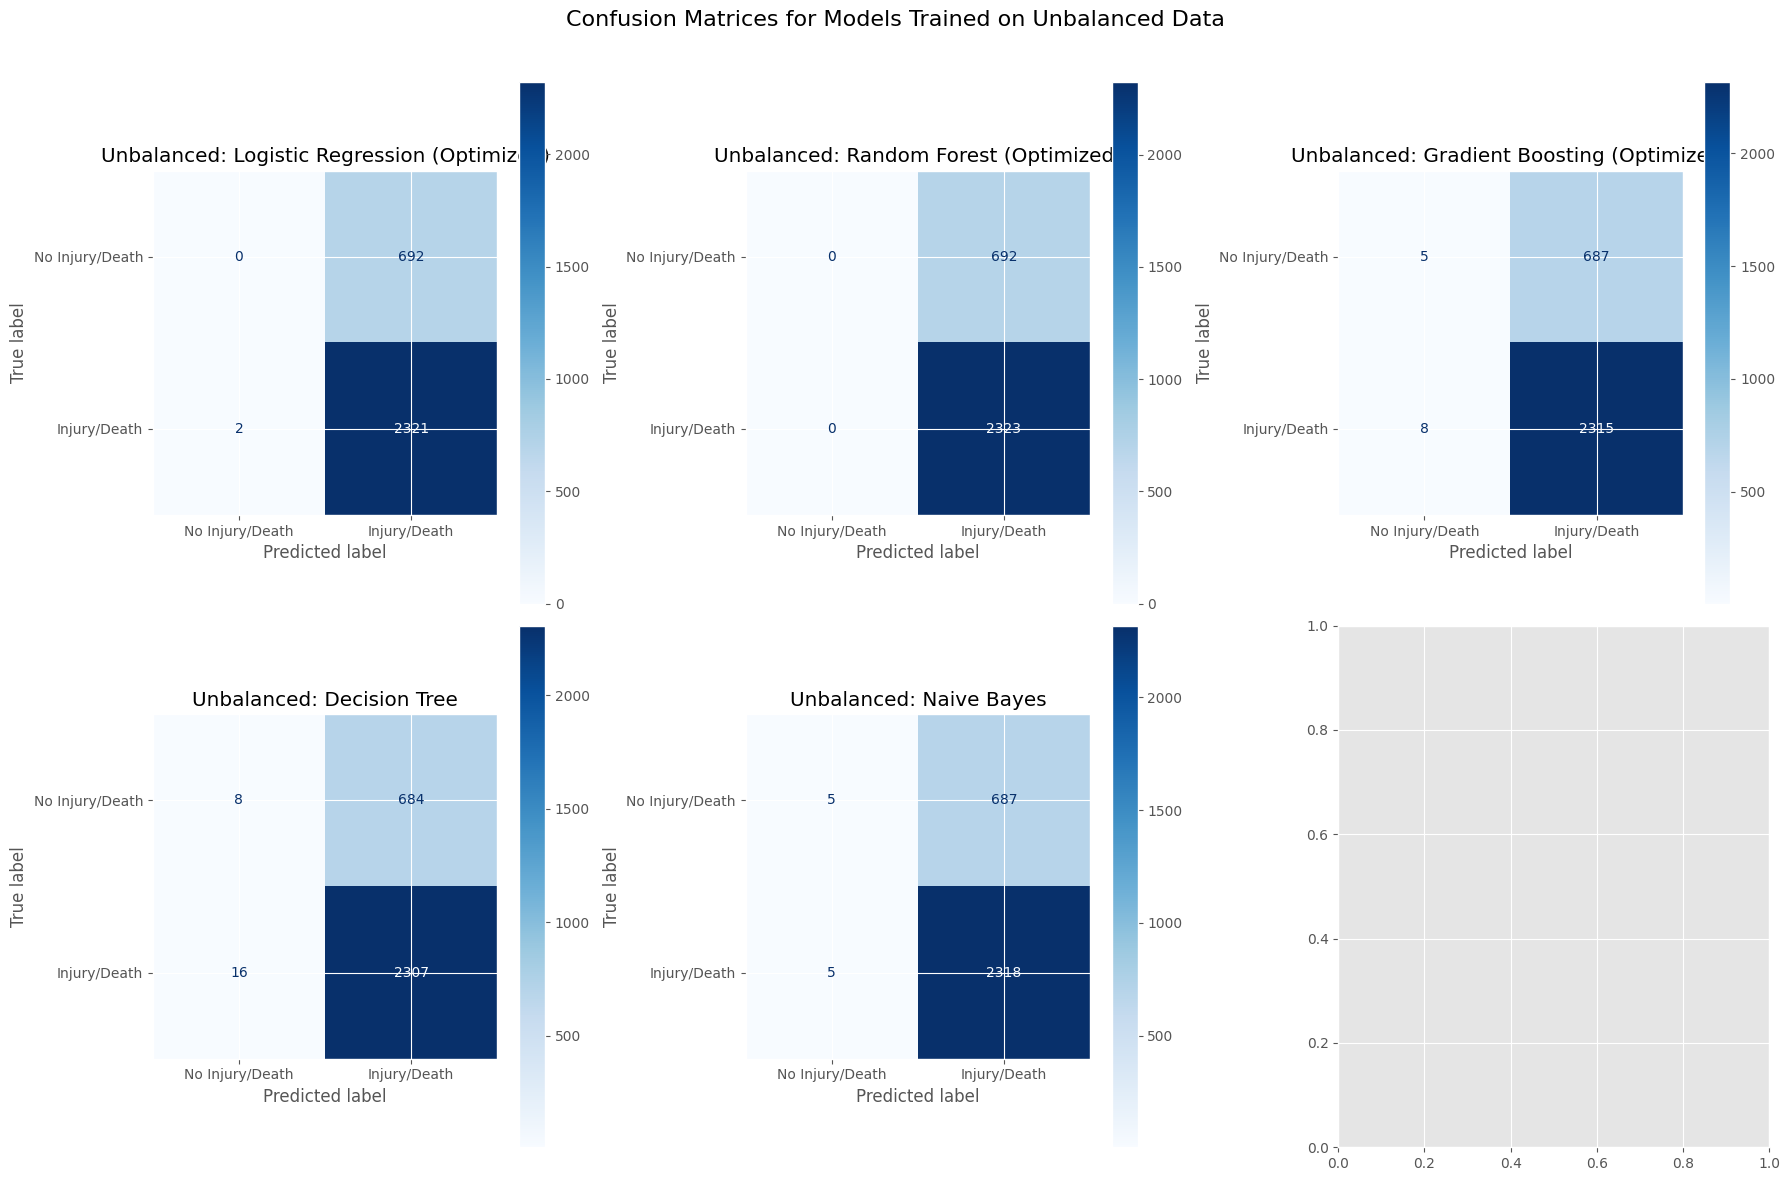

In [18]:
# Confusion Matrices for Unbalanced Models
# Generate and plot confusion matrices for all unbalanced models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dictionary to store trained unbalanced models
unbalanced_fitted_models = {}

# Create a figure with subplots for each unbalanced model
num_models = len(unbalanced_models)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier

# Process each model
for i, (model_name, model) in enumerate(unbalanced_models.items()):
    print(f"\nComputing confusion matrix for unbalanced {model_name}...")
    
    # Train the model if not already done
    model_fitted = model.fit(train_data_transformed)
    unbalanced_fitted_models[model_name] = model_fitted
    
    # Generate predictions
    predictions = model_fitted.transform(test_data_transformed)
    
    # Convert predictions to pandas for sklearn's functions
    y_true = predictions.select(target_classification).toPandas()
    y_pred = predictions.select('prediction').toPandas()
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot on the corresponding subplot
    if i < len(axes):
        ax = axes[i]
        disp = ConfusionMatrixDisplay(cm, display_labels=['No Injury/Death', 'Injury/Death'])
        disp.plot(ax=ax, cmap='Blues', values_format='d')
        ax.set_title(f'Unbalanced: {model_name}')
        
        # Print the confusion matrix values
        print(f"Confusion Matrix for unbalanced {model_name}:")
        print(f"True Negative: {cm[0,0]}")
        print(f"False Positive: {cm[0,1]}")
        print(f"False Negative: {cm[1,0]}")
        print(f"True Positive: {cm[1,1]}")
        
        # Calculate additional metrics
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall (Sensitivity): {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"F1 Score: {f1:.4f}")


plt.tight_layout()
plt.suptitle('Confusion Matrices for Models Trained on Unbalanced Data', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()
